In [1]:
%matplotlib inline

In [14]:
#export
from exp.nb_06 import *
from torch import nn

In [3]:
xTraining, yTraining, xValidation, yValidation = getMnistData()
xTrainingNormalized, xValidationNormalized = normalizeVectors(xTraining, xValidation)
(xTrainingNormalized.mean(), xTrainingNormalized.std, xValidationNormalized.mean(), xValidationNormalized.std())

(tensor(-7.6999e-06),
 <function Tensor.std>,
 tensor(-7.0751e-08),
 tensor(1.0000))

In [4]:
numberOfClasses = 10
hiddenLayerOutput = 50
batchSize = 64
lossFuction = Functional.cross_entropy

In [5]:
trainingDataSet, validationDataSet = Dataset(xTrainingNormalized, yTraining), Dataset(xValidationNormalized, yValidation)

In [6]:
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)

In [7]:
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader, numberOfClasses)

In [8]:
layerSizes = [8, 16, 32, 64, 64]

In [9]:
convolutionalModelSR1 = createBetterConvolutionModel(numberOfClasses, layerSizes)
convolutionalModelSR1

Sequential(
  (0): LambdaLayer()
  (1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRectifiedLinearUnit()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
  )
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): LambdaLayer()
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
accuracy(convolutionalModelSR1(xTraining), yTraining)

tensor(0.0994)

In [11]:
phases = [0.3, 0.7]
weightsScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.3, 0.6, 0.2)) 
biasScheduler = aggregateSchedulers(phases, createCosineSchedulers(0.9, 1.8, 0.6))

In [12]:
teacher = TeacherWithHooks(schedulingFunctions=[weightsScheduler, biasScheduler])

In [13]:
teacher.teachModel(convolutionalModelSR1, imageDataBunch, 2)

Epoch #0 Training: Loss 0.4548206627368927 Accuracy 0.8388347029685974
Epoch #0 Validation: Loss 0.08740277588367462 Accuracy 0.9732001423835754

Epoch #1 Training: Loss 0.1314106285572052 Accuracy 0.9611372947692871
Epoch #1 Validation: Loss 0.14704951643943787 Accuracy 0.9635087251663208



## Layer Normalization

*Internal Covariant Shift*- When the accuracy rate of your model starts to no longer improve at the current learning rate. Only improving when the learning rate becomes smaller, only allowing for marginal returns.

Batch Normalization may negate the need for **layer dropout**. Batch norm works on the **activations** and not the **parameters**

It is important to have parameters such that everytime something is imputing, there is always activations after the matrix multiplication. (I think this allows better gradient calculations?)

$\gamma$(gamma) and $\beta$ (beta) shift normalization of the layer to our pleasing. Which allows us to move our loss in a direction that is smaller (closer to the expected value) $\hat{x} = W\hat{x} + \vec{b}$ 

$\hat{x}$ is the activations. So we want to move the activations closest to y so $\hat{y} = \gamma\hat{x} + \beta$ <- we want that to be close to y ie $0 = y - \hat{y}$

The big issue that this solves is that the gradients (things that help learning) of the loss function are dependent in a highly correlative manner. If the outputs of the previous layer is small (ie the activations) then the learning gradients of the current layer is small as well. Smaller gradients, less learning.  

Batch normalization normally works best with batches that are >32

$C$ = Channel

A channel is a result of applying a **kernel** to the input. Many #channels === #kernels

### Linear Interpolation
Literally finding the slope intercept form and evaluating for x.

In this case the starting vector is the first point and the second point is the second vector.

The two points form a line which can be interpreted as $y = mx+b$ the third argument is the x you are passing (0 gives you the first vector, 1 give you the second vector, 0.5 gives you a vector that is halfway between the two that are on the line that the two points form)

In [43]:
a = torch.tensor([1, 2, 3]).float()
b = torch.tensor([3, 6, 13]).float()
torch.lerp(a, b, .5), torch.lerp(a, b, .0), torch.lerp(a, b, 1)

(tensor([2., 4., 8.]), tensor([1., 2., 3.]), tensor([ 3.,  6., 13.]))

In [52]:
class BatchNormalization(nn.Module):
    def __init__(self, layerSize, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.momentum, self.epsilon = momentum, epsilon
        self.gamma = nn.Parameter(torch.ones(layerSize, 1, 1)) # being a parameter allows it to be adjust in backprop
        self.beta = nn.Parameter(torch.zeros(layerSize, 1, 1)) # ie this is a part of the convolution model.
        self.register_buffer('variances', torch.ones(1, layerSize, 1, 1))
        self.register_buffer('means', torch.zeros(1, layerSize, 1, 1))
        
    def forward(self, activations):
        normalizedActivations = self._normalizeActivations(activations)
        return self.gamma * normalizedActivations + self.beta
    
    def _normalizeActivations(self, activations):
        batchMean, batchVariance = self._getMeanAndVariance(activations)
        return (activations - batchMean) / (batchVariance + self.epsilon).sqrt()
    
    def _getMeanAndVariance(self, activations):
        if self.training:
            with torch.no_grad():
                return self._updateStatistics(activations)
        else:
            return self.means, self.variances

    def _updateStatistics(self, activations):
        batchMeans = activations.mean((0,2,3), keepdim=True)
        batchVariances = activations.var((0, 2, 3), keepdim=True)
        self.means.lerp_(batchMeans, self.momentum) # we only want to step a little bit away from
        self.variances.lerp_(batchVariances, self.momentum) # the stored means eg momentum is tiny
        return batchMeans, batchVariances

In [67]:
def createBatchNormalizedConvolutionLayer(inputSize, 
                                   outputSize, 
                                   kernelSize=3, 
                                   stride=2,
                                   leaky=0.1,
                                   subtractValue=0.4,
                                   maxToClamp=6.0
                                  ):
    layers = [
        torch.nn.Conv2d(inputSize, 
                           outputSize, 
                           kernelSize, 
                           stride, 
                           kernelSize//2), 
       GeneralRectifiedLinearUnit(leaky, 
                                  subtractValue, 
                                  maxToClamp),
        BatchNormalization(outputSize)
    ]
    return torch.nn.Sequential(*layers)

def createBatchNormalizedConvolutionLayers(numberOfClasses, layerSizes):
    adjustedLayerSizes = [1]  + layerSizes # Make the first layer take a dimension of one
    convolutionLayers = [createBatchNormalizedConvolutionLayer(adjustedLayerSizes[i], 
                                               adjustedLayerSizes[i+1],
                                               5 if i == 0 else 3)
                        for i in range(len(adjustedLayerSizes) - 1)]
    finishingLayers = [
        torch.nn.AdaptiveAvgPool2d(1),
        LambdaLayer(flattenImage),
        torch.nn.Linear(layerSizes[-1], numberOfClasses)
    ]
    return [LambdaLayer(resizeImage)] + convolutionLayers + finishingLayers


def createBatchNormalizedConvolutionModel(numberOfClasses, layerSizes):
    newModel = torch.nn.Sequential(*createBatchNormalizedConvolutionLayers(numberOfClasses, layerSizes))
    kaimingInitializeLayers(newModel)
    return newModel

def kaimingInitializeLayers(modelToInitialize):
    for modelLayer in modelToInitialize:
        if isinstance(modelLayer, torch.nn.Sequential):
            init.kaiming_normal_(modelLayer[0].weight, a=0.1)
            modelLayer[0].bias.data.zero_()

In [79]:
convolutionModelSR2 = createBatchNormalizedConvolutionModel(numberOfClasses, layerSizes)
convolutionModelSR2

Sequential(
  (0): LambdaLayer()
  (1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRectifiedLinearUnit()
    (2): BatchNormalization()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
    (2): BatchNormalization()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
    (2): BatchNormalization()
  )
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRectifiedLinearUnit()
    (2): BatchNormalization()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): LambdaLayer()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

In [81]:
accuracy(convolutionModelSR2(xTrainingNormalized), yTraining)

tensor(0.0944)

In [82]:
teacher.teachModel(convolutionModelSR2, imageDataBunch, 8)

Epoch #0 Training: Loss 0.2629697322845459 Accuracy 0.9239529967308044
Epoch #0 Validation: Loss 0.13833773136138916 Accuracy 0.9596518874168396

Epoch #1 Training: Loss 0.1042783334851265 Accuracy 0.9674312472343445
Epoch #1 Validation: Loss 0.14115788042545319 Accuracy 0.9533227682113647

Epoch #2 Training: Loss 0.08636636286973953 Accuracy 0.9728260636329651
Epoch #2 Validation: Loss 0.07346929609775543 Accuracy 0.9785403609275818

Epoch #3 Training: Loss 0.06778375804424286 Accuracy 0.9784207344055176
Epoch #3 Validation: Loss 0.10455094277858734 Accuracy 0.9674643874168396

Epoch #4 Training: Loss 0.05356832221150398 Accuracy 0.9832561016082764
Epoch #4 Validation: Loss 0.058467671275138855 Accuracy 0.9833860993385315

Epoch #5 Training: Loss 0.039953865110874176 Accuracy 0.9876518249511719
Epoch #5 Validation: Loss 0.06101340800523758 Accuracy 0.9823971390724182

Epoch #6 Training: Loss 0.029151055961847305 Accuracy 0.990968644618988
Epoch #6 Validation: Loss 0.05841944366693497 

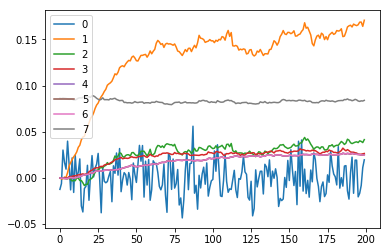

In [86]:
teacher.plotMeans()

Good! all of the means are hovering around Zero!

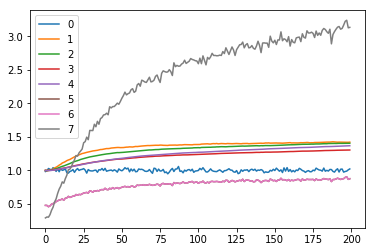

In [87]:
teacher.plotStandardDeviations()

In [88]:
accuracy(convolutionModelSR2(xTrainingNormalized), yTraining), accuracy(convolutionModelSR2(xValidationNormalized), yValidation)

(tensor(0.9960), tensor(0.9844))

### Layer Normalization

The difference between Batch Normalization and Layer normalization is that the activations from the previous layer (in layer normalization) are normalized to the mean and variance of the activation of the previous layer, rather than the average of all of the layers like in batch normalization.

The downside is that every input will look the same going in as it does going out. IE, all really high inputs will look the same as all really low inputs. Whether they are high or low does not matter, just as long as they have low variance, layer norm will make them all look the same. So we loose magnitiude, but gain the ability to have consistent activations throughout our network. So we would not be able to distinguish between hot and cold, as they would all be _normalized_ (ie the same)

In [90]:
class LayerNormalization(nn.Module):
    def __init__(self, layerSize, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.momentum, self.epsilon = momentum, epsilon
        self.gamma = nn.Parameter(torch.ones(layerSize, 1, 1)) # being a parameter allows it to be adjust in backprop
        self.beta = nn.Parameter(torch.zeros(layerSize, 1, 1)) # ie this is a part of the convolution model.
        
    def forward(self, activations):
        normalizedActivations = self._normalizeActivations(activations)
        return self.gamma * normalizedActivations + self.beta
    
    def _normalizeActivations(self, activations):
        batchMean, batchVariance = self._getMeanAndVariance(activations)
        return (activations - batchMean) / (batchVariance + self.epsilon).sqrt()
    
    def _getMeanAndVariance(self, activations):
        layerMeans = activations.mean((0,2,3), keepdim=True)
        layerVariances = activations.var((0, 2, 3), keepdim=True)
        return layerMeans, layerVariances

### Instance Normalization

Instance normalization takes away any grouping. Layer normalization uses the entire layer's output mean/variance, batch normalization uses the entire dataset's mean/variance. Instance normalization just normalizes one 

### Group Normalization

Very similar to the Layer initialization, but we break the layer int mostly equally sized groups.

**Model To Tensor**

tensor.shape -> torch.Size([500, 8, 78, 78])
- 500 == Number of items to be processed (ie, batch)
- 8 == Number of channels (ie, how many kernel's processed the input
- 78 x78 == Shape of the input matrix.

### Baby Batch Norm


In [135]:
rando = torch.randn((5, 3, 4, 4))
rando.shape

torch.Size([5, 3, 4, 4])

In [136]:
summy = rando.sum((0, 2, 3), keepdim=True)
summy, summy.shape, summy.numel()

(tensor([[[[11.5323]],
 
          [[-7.3790]],
 
          [[-4.9058]]]]), torch.Size([1, 3, 1, 1]), 3)

In [139]:
rando.numel() // rando.shape[1], rando[1].numel()

(80, 48)

In [143]:
otherSummy = rando.sum(0, keepdim=True)
otherSummy.shape, otherSummy.numel()

(torch.Size([1, 3, 4, 4]), 48)

### ☝️Adds up all the stuff into the channel dimension

In [131]:
#export
class BabyBatchNormalizationLayer(nn.Module):
    def __init__(self, layerSize, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.momentum, self.epsilon, self.layerSize = momentum, epsilon, layerSize
        self.gamma = nn.Parameter(torch.ones(layerSize, 1, 1))
        self.beta = nn.Parameter(torch.zeros(layerSize, 1, 1))
        self.register_buffer("aggregatedGamma", torch.zeros(1, layerSize, 1, 1))
        self.register_buffer("aggregatedBeta", torch.zeros(1, layerSize, 1, 1))
        self.register_buffer("batch", torch.tensor(0.))
        self.register_buffer("counts", torch.tensor(0.))
        self.register_buffer("step", torch.tensor(0.))
        self.register_buffer("bias", torch.tensor(0.))
    
    def forward(self, activations):
        normalizedActivations = self._normalizeActivations(activations)
        return self.gamma * normalizedActivations + self.beta
    
    def _normalizeActivations(self, activations):
        batchMean, batchVariance = self._getMeanAndVariance(activations)
        return (activations - batchMean) / (batchVariance + self.epsilon).sqrt()
    
    def _getMeanAndVariance(self, activations):
        if self.training:
            with torch.no_grad():
                return self._updateStatistics(activations)
        else:
            return self.means, self.variances

    def _updateStatistics(self, activations):
        self.aggregatedGamma.detatch_()
        self.aggregatedBeta.detatch_()
        batchSize, numberOfChannels, *_ = activations.shape
        channelSum = activations.sum((0,2,3), keepdim=True)
        channelSquared = (activations * activations).sum((0, 2, 3), keepdim=True)
        
        momentum = (1 - (1-self.momentum)/math.sqrt(self.batchSize-1))
        
        counts = channelSum.new_tensor()
        
        self.means.lerp_(batchMeans, self.momentum) # we only want to step a little bit away from
        self.variances.lerp_(batchVariances, self.momentum) # the stored means eg momentum is tiny
        return batchMeans, batchVariances

In [99]:
def createBabyBatchNormalizedConvolutionLayer(inputSize, 
                                   outputSize, 
                                   kernelSize=3, 
                                   stride=2,
                                   leaky=0.1,
                                   subtractValue=0.4,
                                   maxToClamp=6.0
                                  ):
    layers = [
        torch.nn.Conv2d(inputSize, 
                           outputSize, 
                           kernelSize, 
                           stride, 
                           kernelSize//2), 
       GeneralRectifiedLinearUnit(leaky, 
                                  subtractValue, 
                                  maxToClamp),
        BabyBatchNormalizationLayer(outputSize)
    ]
    return torch.nn.Sequential(*layers)

def createBabyBatchNormalizedConvolutionLayers(numberOfClasses, layerSizes):
    adjustedLayerSizes = [1]  + layerSizes # Make the first layer take a dimension of one
    convolutionLayers = [createBatchNormalizedConvolutionLayer(adjustedLayerSizes[i], 
                                               adjustedLayerSizes[i+1],
                                               5 if i == 0 else 3)
                        for i in range(len(adjustedLayerSizes) - 1)]
    finishingLayers = [
        torch.nn.AdaptiveAvgPool2d(1),
        LambdaLayer(flattenImage),
        torch.nn.Linear(layerSizes[-1], numberOfClasses)
    ]
    return [LambdaLayer(resizeImage)] + convolutionLayers + finishingLayers


def createBabyBatchNormalizedConvolutionModel(numberOfClasses, layerSizes):
    newModel = torch.nn.Sequential(*createBatchNormalizedConvolutionLayers(numberOfClasses, layerSizes))
    kaimingInitializeLayers(newModel)
    return newModel